# 1 - Libraries

In [1]:
# Libary untuk proses Data
import numpy as np
import pandas as pd
import pickle

# Library untuk Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pylab
from statsmodels.tsa.seasonal import seasonal_decompose

# Library Model
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Library Metriks
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

# 2 - Data Loading

In [2]:
df_ori = pd.read_csv("shrimp_prices_week.csv")
df_ori

,date,size_30,size_40,size_50,size_60,size_70,size_80,size_100
0,2018-09-16,101000.0,90000.000000,81000.000000,77000.000000,74000.000000,71000.000000,65000.000000
1,2018-09-23,99800.0,88666.666667,80333.333333,76333.333333,73333.333333,70333.333333,64333.333333
2,2018-09-30,98600.0,87333.333333,79666.666667,75666.666667,72666.666667,69666.666667,63666.666667
3,2018-10-07,97400.0,86000.000000,79000.000000,75000.000000,72000.000000,69000.000000,63000.000000
4,2018-10-14,96200.0,84666.666667,78333.333333,74333.333333,71333.333333,68333.333333,62333.333333
...,...,...,...,...,...,...,...,...
310,2024-08-25,80000.0,75000.000000,68000.000000,65000.000000,62000.000000,60000.000000,34683.666667
311,2024-09-01,82500.0,76000.000000,68500.000000,65500.000000,61500.000000,59000.000000,53500.000000
312,2024-09-08,80000.0,74000.000000,68000.000000,66000.000000,62000.000000,60000.000000,54000.000000
313,2024-09-15,79000.0,74000.000000,68000.000000,66000.000000,62000.000000,60000.000000,54000.000000


Load dataset hasil scrapping dan cleaning

In [3]:
df_80 = df_ori[['date','size_80']]
df_80

,date,size_80
0,2018-09-16,71000.000000
1,2018-09-23,70333.333333
2,2018-09-30,69666.666667
3,2018-10-07,69000.000000
4,2018-10-14,68333.333333
...,...,...
310,2024-08-25,60000.000000
311,2024-09-01,59000.000000
312,2024-09-08,60000.000000
313,2024-09-15,60000.000000


Seleksi kolom yang akan dijadikan dataset training

In [4]:
df_80['date'] = pd.to_datetime(df_80['date'])
df_80.set_index('date',inplace=True)
df_80.head()

,size_80
date,
2018-09-16,71000.000000
2018-09-23,70333.333333
2018-09-30,69666.666667
2018-10-07,69000.000000
2018-10-14,68333.333333


Mengubah `date` menjadi indeks

# 3 - EDA Modeling

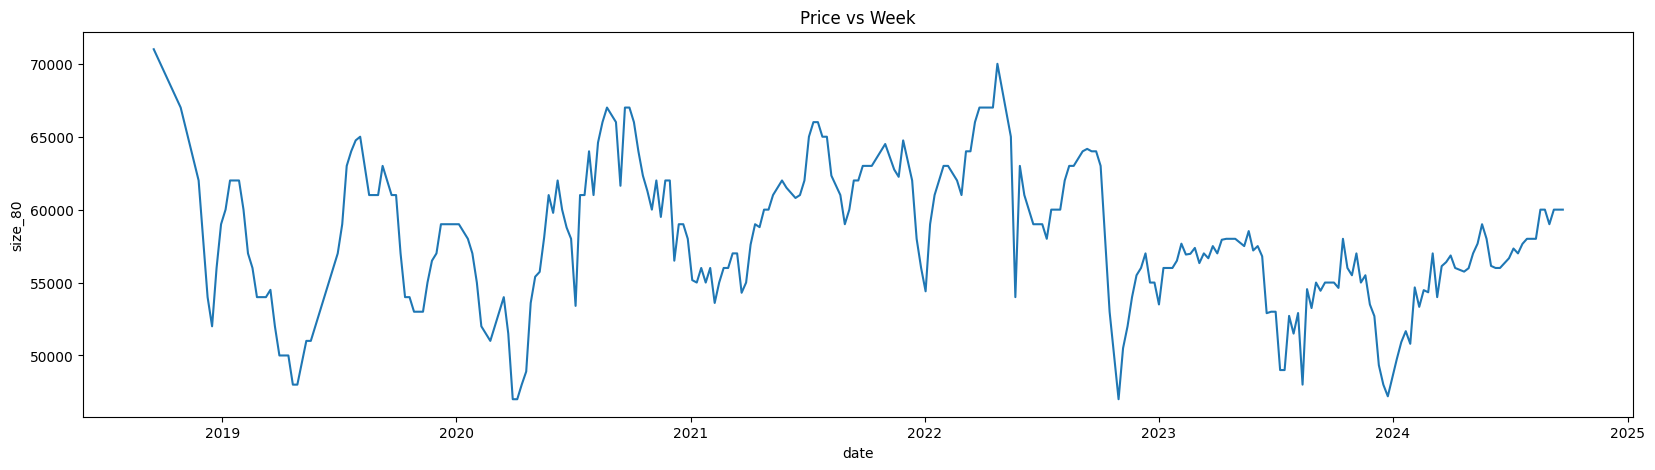

In [7]:
# Visualisasi data
fig,ax = plt.subplots(nrows = 1, ncols = 1,figsize = (20,5))
plt.subplot(1,1,1)
sns.lineplot(x = df_80.index ,y = 'size_80',data = df_80)
plt.title('Price vs Week');

Plot visual dari keseluruhan data harga udang size 80

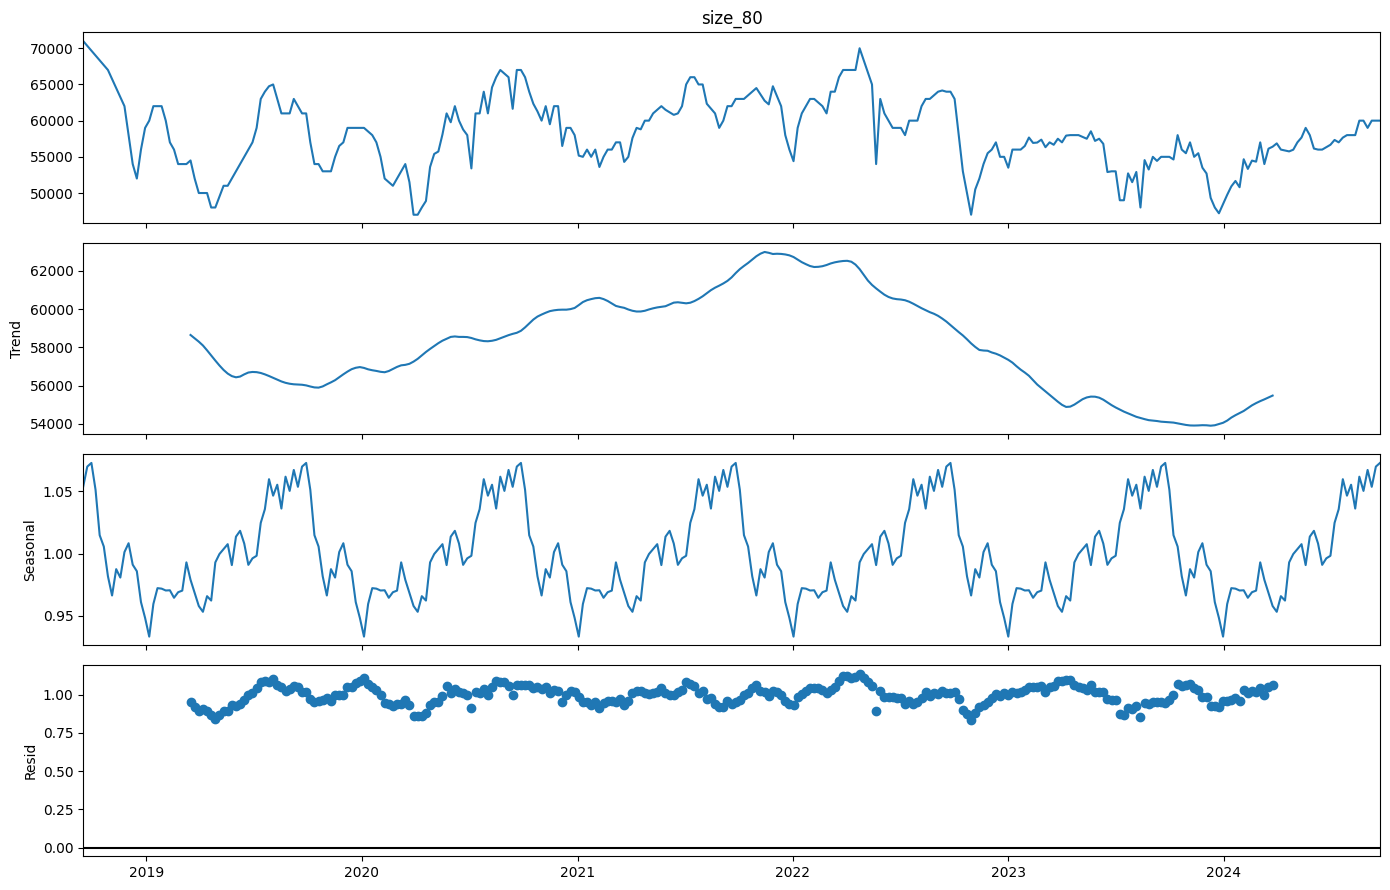

In [8]:
# Dekomposisi timeseries

pylab.rcParams['figure.figsize'] = (14, 9)
res = seasonal_decompose(df_80['size_80'], model='multiplicatif')
ax=res.plot()
plt.show()

Data memiliki pola seasonal tahunan dengan trend terakhir sedang terdapat kenaikan


In [6]:
# fungsi untuk memeriksa stationarity data

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

Fungsi untuk memeriksa Stationarity

In [7]:
# Proses check stationarity
check_stationarity(df_80['size_80'])

ADF Statistic: -4.618433
p-value: 0.000119
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572
Stationary


Check stationarity menghasilkan statement stationary yang artinya bisa parameter turunan (D) = 0

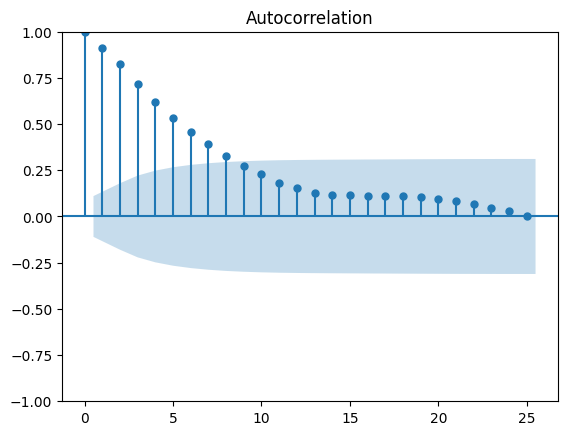

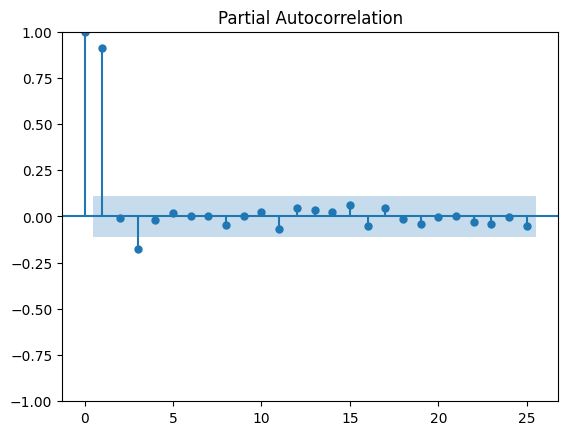

In [8]:
# Visualisasi Plot ACF & PACF

plot_acf(df_80['size_80'])
plot_pacf(df_80['size_80'])
plt.show()

Berdasarkan plot Autocorrelation (Q) dan Partial Autocorrelation (P) didapat nilai Q = 8 dan P = 3. Hal ini berarti model akan menggunakan parameter P = 3, D = 0, Q = 8

In [13]:
# Membuat fungsi untuk mencari best model berdasarkan ARIMA

def find_best_model(data, num_p, num_d, num_q):
  df = pd.DataFrame() #We make a pandas dataframe to ease our work, you can use any way that makes you comfortable and work easly
  pdq = [[],[],[]] #This list for storing the combinations of p and q
  aic = [] # This list for storing aic value
  for p in range(num_p + 1): #plus one is to make the range up to num_p since python range only ranging from 0 to N-1
    for d in range(num_d + 1):
      for q in range(num_q + 1):
        # #if p!=0 and q!=0: #this logic will avoid (0,0) value which is not correct
        try: #Using exception to avoid the error while training the model with certain p and q value
          model = ARIMA(data, order=(p, d, q))
          result = model.fit()
          pdq[0].append(p)
          pdq[1].append(d)
          pdq[2].append(q)
          aic.append(result.aic)
        except:
          pass #If there is an error caused by the calculation, it will be skipped to the next iteration

  df['p'] = pdq[0]
  df['d'] = pdq[1]
  df['q'] = pdq[2]
  df['AIC'] = aic

  df.sort_values('AIC', inplace=True)

  return df.p.iloc[0], df.d.iloc[0], df.q.iloc[0], df.AIC.iloc[0], df

Fungsi untuk mencari nilai PDQ optimal

In [9]:
train = df_80[:250]
test = df_80[250:]
print(f"Train Size : {train.shape}")
print(f"Test Size : {test.shape}")

Train Size : (250, 1)
Test Size : (65, 1)


Split Train set sebanyak 250 data, dan Test set sebanyak 65 data

In [17]:
# Proses mencari best model
find_best_model(train['size_80'],10,10,10)

Hasil Pencarian model didapat PDQ 5,9,1 dengan AIC 14.0

# 4 - Model Training

## 4.1 - ARIMA

### 4.1.1 - ARIMA Visual Plot

In [21]:
# Menggunakan parameter PDQ dari plot visual

model_arima_visual = ARIMA(train['size_80'], order=(3,0,8))
result_model_arima_visual = model_arima_visual.fit()

print("AIC ARIMA Visual :",result_model_arima_visual.aic)

AIC ARIMA Visual : 4517.522827728404


Hasil training ARIMA dengan PDQ 3,0,8 didapat AIC sebesar 4517.52

### 4.1.2 - ARIMA Find Best Model

In [34]:
# Menggunakan parameter PDQ dari fungsi find best model
model_arima_find = ARIMA(train['size_80'], order=(5,9,1))
result_model_arima_find = model_arima_find.fit()

print("AIC ARIMA Fungsi Find :",result_model_arima_find.aic)

AIC ARIMA Fungsi Find : 14.0


Proses Training dengan PDQ 5,9,1 menghasilkan AIC sebesar 14.0

## 4.2 - SARIMA

### 4.2.1 - SARIMA Visual Plot

In [10]:
# # Menggunakan parameter PDQ dari plot visual

sar_visual=SARIMAX(train['size_80'], order=(3, 0, 8),seasonal_order=(3, 0, 8, 52)).fit()
sar_visual.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            size_80   No. Observations:                  250
Model:             SARIMAX(3, 0, 8)x(3, 0, 8, 52)   Log Likelihood               -2253.359
Date:                            Thu, 26 Sep 2024   AIC                           4552.717
Time:                                    09:35:20   BIC                           4633.711
Sample:                                09-16-2018   HQIC                          4585.315
                                     - 06-25-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4658      0.213     -2.189      0.029      -0.883      -0.049
ar.L2          0.5814      0.136      4.277      0.000       0.315       0.848
ar.L3          0.8829      0.209      4.221      0.000       0.473       1.293
ma.L1          1.5080      0.212      7.123      0.000       1.093       1.923
ma.L2          1.0902      0.259      4.211      0.000       0.583       1.598
ma.L3          0.1971      0.159      1.237      0.216      -0.115       0.509
ma.L4         -0.0473      0.161     -0.293      0.770      -0.363       0.269
ma.L5         -0.2611      0.155     -1.686      0.092      -0.565       0.042
ma.L6         -0.2353      0.163     -1.446      0.148      -0.554       0.084
ma.L7         -0.0491      0.167     -0.294      0.769      -0.376       0.278
ma.L8          0.0214      0.095      0.224      0.823      -0.165       0.208
ar.S.L52       0.1303     17.861      0.007      0.994     -34.877      35.137
ar.S.L104      0.3525     43.976      0.008      0.994     -85.838      86.543
ar.S.L156      0.0469     13.010      0.004      0.997     -25.453      25.547
ma.S.L52      -0.1053     19.133     -0.006      0.996     -37.604      37.394
ma.S.L104     -0.3064     44.448     -0.007      0.994     -87.422      86.809
ma.S.L156     -0.0757     13.665     -0.006      0.996     -26.859      26.707
ma.S.L208     -0.1781      3.957     -0.045      0.964      -7.934       7.577
ma.S.L260      0.0328     11.213      0.003      0.998     -21.944      22.010
ma.S.L312      0.0413     14.782      0.003      0.998     -28.930      29.013
ma.S.L364      0.0183     18.901      0.001      0.999     -37.026      37.063
ma.S.L416      0.0378     18.010      0.002      0.998     -35.260      35.336
sigma2      3.963e+06      0.000   1.94e+10      0.000    3.96e+06    3.96e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               273.97
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.76   Skew:                             0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.6e+27. Standard errors may be unstable.
"""

Proses Training menggunakan SARIMA dengan PDQ 3,0,8 menghasilkan AIC sebesar 4552.7

### 4.2.2 - SARIMA Find Best Model

In [11]:
# # Menggunakan parameter PDQ dari fungsi find best model

sar_find=SARIMAX(train['size_80'], order=(5, 9, 1),seasonal_order=(5, 9, 1, 52)).fit()
sar_find.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            size_80   No. Observations:                  250
Model:             SARIMAX(5, 9, 1)x(5, 9, 1, 52)   Log Likelihood                   0.000
Date:                            Thu, 26 Sep 2024   AIC                             26.000
Time:                                    09:43:43   BIC                                nan
Sample:                                09-16-2018   HQIC                               nan
                                     - 06-25-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1              -0         -0        nan        nan           0          -0
ar.L2              -0         -0        nan        nan           0          -0
ar.L3               0         -0        nan        nan           0           0
ar.L4               0         -0        nan        nan           0           0
ar.L5               0         -0        nan        nan           0           0
ma.L1               0         -0        nan        nan           0           0
ar.S.L52           -0         -0        nan        nan           0          -0
ar.S.L104          -0         -0        nan        nan           0          -0
ar.S.L156           0         -0        nan        nan           0           0
ar.S.L208           0         -0        nan        nan           0           0
ar.S.L260           0         -0        nan        nan           0           0
ma.S.L52            0         -0        nan        nan           0           0
sigma2         1.0000         -0       -inf      0.000       1.000       1.000
===================================================================================
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                               nan   Prob(JB):                          nan
Heteroskedasticity (H):                nan   Skew:                              nan
Prob(H) (two-sided):                   nan   Kurtosis:                          nan
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

Proses Training menggunakan SARIMA dengan PDQ 5,9,1 menghasilkan AIC sebesar 26.0

# 5 - Model Evaluation

## 5.1 - ARIMA

### 5.1.1 - Visual Plot

In [37]:
arima_pred_test_viz = result_model_arima_visual.predict(start="2023-07-02", end="2024-09-22",dynamic=True)
arima_pred_test_viz = pd.DataFrame(arima_pred_test_viz)
arima_pred_test_viz.columns = ['price_predict_vizplot']

Proses predict dilakukan mulai tanggal `2023-07-02` hingga `2024-09-22`

In [38]:
# Concate dengan actual test set
act_vs_pred_arima = pd.concat([test, arima_pred_test_viz],axis=1)
act_vs_pred_arima

,size_80,price_predict_vizplot
2023-07-02,53000.000000,52805.397425
2023-07-09,49000.000000,53575.505738
2023-07-16,49000.000000,54182.922973
2023-07-23,52714.285714,54942.929613
2023-07-30,51500.000000,55526.300333
...,...,...
2024-08-25,60000.000000,59071.604404
2024-09-01,59000.000000,59067.369818
2024-09-08,60000.000000,59072.444049
2024-09-15,60000.000000,59068.804320


Hasil prediksi terlihat cukup sesuai dengan harga aktual test-set

In [24]:
size = int(len(df_80) - 30)
train_v2, test_v2 = df_80['size_80'][0:size], df_80['size_80'][size:len(df_80)]

print('\t ARIMA MODEL : In- Sample Forecasting \n')

history = [x for x in train_v2]
predictions = []

for t in range(len(test_v2)):
    
    model = ARIMA(history, order=(3,0,8))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test_v2[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))

	 ARIMA MODEL : In- Sample Forecasting 

predicted = 54667.282660, expected = 57000.000000
predicted = 57233.819752, expected = 54000.000000
predicted = 54618.726347, expected = 56125.000000
predicted = 55984.317202, expected = 56400.000000
predicted = 56845.931408, expected = 56857.142857
predicted = 57084.280954, expected = 56000.000000
predicted = 56729.632238, expected = 55875.000000
predicted = 55918.621761, expected = 55750.000000
predicted = 55592.478918, expected = 55984.375000
predicted = 56511.985448, expected = 57000.000000
predicted = 57240.271064, expected = 57666.666667
predicted = 57788.540480, expected = 59000.000000
predicted = 59230.922949, expected = 58000.000000
predicted = 58181.903772, expected = 56142.857143
predicted = 56001.433280, expected = 56000.000000
predicted = 55815.325926, expected = 56000.000000
predicted = 56024.543277, expected = 56333.333333
predicted = 56664.221921, expected = 56666.666667
predicted = 57134.233943, expected = 57333.333333
predicted

In [23]:
print('MAE test  : ', mean_absolute_error(test, arima_pred_test_viz))
print('RMSE test : ', np.sqrt(mean_squared_error(test, arima_pred_test_viz)))

MAE test  :  3584.5167110506522
RMSE test :  4507.699135747741


In [25]:
# Menghitung MAPE
mape = np.mean(np.abs((test_v2 - predictions) / test_v2)) * 100

print('MAPE test : ', mape)

MAPE test :  1.3066986583553153


Evaluasi error menghasilkan angka yang cukup bagus yaitu MAE 3584.51, RMSE 4507.69, dan MAPE 1.3%

### 5.1.2 - Find Best Model Function

In [39]:
arima_pred_test_find = result_model_arima_find.predict(start="2023-07-02", end="2024-09-22")
arima_pred_test_find = pd.DataFrame(arima_pred_test_find)
arima_pred_test_find.columns = ['price_predict_findfunc']


act_vs_pred_arima['price_predict_findfunc'] = arima_pred_test_find['price_predict_findfunc']
act_vs_pred_arima

,size_80,price_predict_vizplot,price_predict_findfunc
2023-07-02,53000.000000,52805.397425,-1.477123e+19
2023-07-09,49000.000000,53575.505738,-1.524688e+19
2023-07-16,49000.000000,54182.922973,-1.573588e+19
2023-07-23,52714.285714,54942.929613,-1.623855e+19
2023-07-30,51500.000000,55526.300333,-1.675521e+19
...,...,...,...
2024-08-25,60000.000000,59071.604404,-8.159079e+19
2024-09-01,59000.000000,59067.369818,-8.370690e+19
2024-09-08,60000.000000,59072.444049,-8.587088e+19
2024-09-15,60000.000000,59068.804320,-8.808365e+19


Namun ketika dicoba menggunakan PDQ 5,9,1 hasil prediksinya melenceng jauh dari aktual test-set

In [41]:
size = int(len(df_80) - 30)
train_v2, test_v2 = df_80['size_80'][0:size], df_80['size_80'][size:len(df_80)]

print('\t ARIMA MODEL : In- Sample Forecasting \n')

history = [x for x in train_v2]
predictions = []

for t in range(len(test_v2)):
    
    model = ARIMA(history, order=(5,9,1))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test_v2[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))

	 ARIMA MODEL : In- Sample Forecasting 

predicted = 61793.180486, expected = 57000.000000
predicted = 72280.859390, expected = 54000.000000
predicted = 23564.655834, expected = 56125.000000
predicted = 73137.826872, expected = 56400.000000
predicted = 63781.082519, expected = 56857.142857
predicted = 46645.998528, expected = 56000.000000
predicted = 50197.607417, expected = 55875.000000
predicted = 61355.871963, expected = 55750.000000
predicted = 65749.199238, expected = 55984.375000
predicted = 47155.621873, expected = 57000.000000
predicted = 58044.413229, expected = 57666.666667
predicted = 54376.364063, expected = 59000.000000
predicted = 68528.728853, expected = 58000.000000
predicted = 47417.833758, expected = 56142.857143
predicted = 55232.167262, expected = 56000.000000
predicted = 67629.859396, expected = 56000.000000
predicted = 54097.261471, expected = 56333.333333
predicted = 46026.866879, expected = 56666.666667
predicted = 55282.519060, expected = 57333.333333
predicted

In [40]:
print('MAE test  : ', mean_absolute_error(test, arima_pred_test_find))
print('RMSE test : ', np.sqrt(mean_squared_error(test, arima_pred_test_find)))

MAE test  :  4.324150395836866e+19
RMSE test :  4.846627767733659e+19


In [42]:
# Menghitung MAPE
mape = np.mean(np.abs((test_v2 - predictions) / test_v2)) * 100

print('MAPE test : ', mape)

MAPE test :  13.787182411837314


Untuk Evaluasi model yang menggunakan fungsi Find PDQ terlihat error yang cukup besar dibanding dengan visual plot

## 5.2 - SARIMA

### 5.2.1 - Visual Plot

In [12]:
sarima_pred_test_viz = sar_visual.predict(start="2023-07-02", end="2024-09-22", dynamic=True)
sarima_pred_test_viz = pd.DataFrame(sarima_pred_test_viz)
sarima_pred_test_viz.columns = ['price_predict']

# Concate dengan actual test set
act_vs_pred_sar = pd.concat([test, sarima_pred_test_viz],axis=1)
act_vs_pred_sar

,size_80,price_predict
2023-07-02,53000.000000,52313.853381
2023-07-09,49000.000000,51950.345514
2023-07-16,49000.000000,52015.632170
2023-07-23,52714.285714,52076.112307
2023-07-30,51500.000000,52229.540583
...,...,...
2024-08-25,60000.000000,50121.825160
2024-09-01,59000.000000,50211.601330
2024-09-08,60000.000000,50872.196748
2024-09-15,60000.000000,49949.749490


Proses prediksi menghasilkan prediksi yang cukup melenceng dari aktual

In [29]:
size = int(len(df_80) - 30)
train_v2, test_v2 = df_80['size_80'][0:size], df_80['size_80'][size:len(df_80)]
print('\t ARIMA MODEL : In- Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test_v2)):
    
    
    output = sar_visual.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test_v2[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))

	 ARIMA MODEL : In- Sample Forecasting 

predicted = 52313.853381, expected = 57000.000000
predicted = 52313.853381, expected = 54000.000000
predicted = 52313.853381, expected = 56125.000000
predicted = 52313.853381, expected = 56400.000000
predicted = 52313.853381, expected = 56857.142857
predicted = 52313.853381, expected = 56000.000000
predicted = 52313.853381, expected = 55875.000000
predicted = 52313.853381, expected = 55750.000000
predicted = 52313.853381, expected = 55984.375000
predicted = 52313.853381, expected = 57000.000000
predicted = 52313.853381, expected = 57666.666667
predicted = 52313.853381, expected = 59000.000000
predicted = 52313.853381, expected = 58000.000000
predicted = 52313.853381, expected = 56142.857143
predicted = 52313.853381, expected = 56000.000000
predicted = 52313.853381, expected = 56000.000000
predicted = 52313.853381, expected = 56333.333333
predicted = 52313.853381, expected = 56666.666667
predicted = 52313.853381, expected = 57333.333333
predicted

In [19]:
# Check the MAE

print('MAE test  : ', mean_absolute_error(test, sarima_pred_test_viz))
print('RMSE test : ', np.sqrt(mean_squared_error(test, sarima_pred_test_viz)))


MAE test  :  3837.853090371602
RMSE test :  4694.754806019224


In [30]:
# Menghitung MAPE
mape = np.mean(np.abs((test_v2 - predictions) / test_v2)) * 100

print('MAPE test : ', mape)

MAPE test :  8.784001336202687


Hasil test error menunjukkan MAPE sebesar 8.7% sedangkan MAE 3837.85 dengan RMSE 4694.75

### 5.2.2 - Find Best Model Function

In [14]:
sarima_pred_test_find = sar_find.predict(start="2023-07-02", end="2024-09-22", dynamic=True)
sarima_pred_test_find = pd.DataFrame(sarima_pred_test_find)
sarima_pred_test_find.columns = ['price_predict_find']

# Concate dengan actual test set
act_vs_pred_sar['price_predict_find'] = sarima_pred_test_find['price_predict_find']
act_vs_pred_sar

,size_80,price_predict,price_predict_find
2023-07-02,53000.000000,52313.853381,-2.346336e+06
2023-07-09,49000.000000,51950.345514,-2.077545e+07
2023-07-16,49000.000000,52015.632170,-1.022092e+08
2023-07-23,52714.285714,52076.112307,-3.687924e+08
2023-07-30,51500.000000,52229.540583,-1.090492e+09
...,...,...,...
2024-08-25,60000.000000,50121.825160,-1.655565e+16
2024-09-01,59000.000000,50211.601330,-1.878374e+16
2024-09-08,60000.000000,50872.196748,-2.127110e+16
2024-09-15,60000.000000,49949.749490,-2.404332e+16


Hasil prediksi menunjukkan angka minus yang berarti sangat tidak akurat

In [31]:
size = int(len(df_80) - 30)
train_v2, test_v2 = df_80['size_80'][0:size], df_80['size_80'][size:len(df_80)]
print('\t ARIMA MODEL : In- Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test_v2)):
    
    
    output = sar_find.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test_v2[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))

	 ARIMA MODEL : In- Sample Forecasting 

predicted = -2346336.290161, expected = 57000.000000
predicted = -2346336.290161, expected = 54000.000000
predicted = -2346336.290161, expected = 56125.000000
predicted = -2346336.290161, expected = 56400.000000
predicted = -2346336.290161, expected = 56857.142857
predicted = -2346336.290161, expected = 56000.000000
predicted = -2346336.290161, expected = 55875.000000
predicted = -2346336.290161, expected = 55750.000000
predicted = -2346336.290161, expected = 55984.375000
predicted = -2346336.290161, expected = 57000.000000
predicted = -2346336.290161, expected = 57666.666667
predicted = -2346336.290161, expected = 59000.000000
predicted = -2346336.290161, expected = 58000.000000
predicted = -2346336.290161, expected = 56142.857143
predicted = -2346336.290161, expected = 56000.000000
predicted = -2346336.290161, expected = 56000.000000
predicted = -2346336.290161, expected = 56333.333333
predicted = -2346336.290161, expected = 56666.666667
predi

In [20]:
# Check the MAE

print('MAE test  : ', mean_absolute_error(test, sarima_pred_test_find))
print('RMSE test : ', np.sqrt(mean_squared_error(test, sarima_pred_test_find)))

MAE test  :  3319223348283080.5
RMSE test :  7101127667297438.0


In [32]:
# Menghitung MAPE
mape = np.mean(np.abs((test_v2 - predictions) / test_v2)) * 100

print('MAPE test : ', mape)

MAPE test :  4191.142098647447


Hasil error juga menunjukkan angka yang fantastis besarnya. Ini mengartikan model sangat tidak bisa memprediksi data

# 6 - Conclusion

Dari hasil evaluasi yang telah dilakukan, model ARIMA dengan PDQ dari Plot Visual lebih menunjukkan prediksi yang lebih akurat daripada PDQ yang didapat dari find best model maupun model SARIMA.

Hal ini bisa dilihat dari angka error yang ditunjukkan oleh RMSE, MAE, dan MAPE yang jelas perbedaannya. RMSE, MAE, dan MAPE ARIMA lebih rendah daripada SARIMA sehingga model yang akan dipakai untuk memprediksi data harga udang size 80 yaitu Model ARIMA dengan PDQ 3,0,8

# 7 - Model Saving

In [55]:
with open('model80.pkl','wb') as model80_file:
    pickle.dump(result_model_arima_visual, model80_file)

Save Model ARIMA PDQ Visual Plot ke dalam bentuk file pickle